In [64]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import glob
import time
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from skimage import data, exposure

# Read car images

In [4]:
# Read in car and non-car images
images = glob.glob('vehicles/*/*/*.png')
cars = []
notcars = []
for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
print('Found {} cars and {} noncars'.format(len(cars), len(notcars)))

Found 8792 cars and 8968 noncars


# Extracting HOG features and color histograms

In [6]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,pixels_per_cell=(pix_per_cell, pix_per_cell),cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel="ALL",
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):                    
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features) 
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## HOG features Car Example

/home/bartdezwaan/anaconda2/envs/mlbook/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


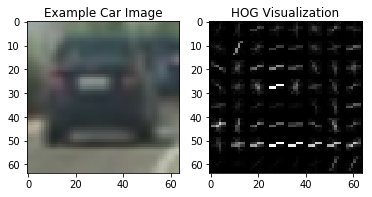

In [63]:
# Read in the image
image = mpimg.imread(cars[1])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient= 15, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)

cv2.imwrite("output_images/car.png", image*255)

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))
cv2.imwrite("output_images/hog_car_features.jpg", hog_image_rescaled*255)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()

## HOG features Not Car Example

/home/bartdezwaan/anaconda2/envs/mlbook/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


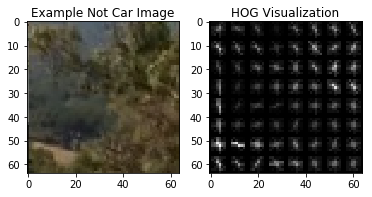

In [65]:
# Read in the image
image = mpimg.imread(notcars[1])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient= 15, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)

cv2.imwrite("output_images/notcar.png", image*255)
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))
cv2.imwrite("output_images/hog_notcar_features.jpg", hog_image_rescaled*255)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Not Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()

# Training a classifier

In [66]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 15  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial_size,
    'and', hist_bins,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC(C=0.001)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

/home/bartdezwaan/anaconda2/envs/mlbook/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using spatial binning of: (16, 16) and 16 histogram bins
Feature vector length: 2436
2.54 Seconds to train SVC...
Test Accuracy of SVC =  0.9924
My SVC predicts:  [ 1.  0.  0.  1.  0.  0.  0.  0.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  1.  0.  0.  0.  0.  1.  1.]
0.00377 Seconds to predict 10 labels with SVC


In [67]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    b_boxes = []

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                b_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return b_boxes

/home/bartdezwaan/anaconda2/envs/mlbook/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


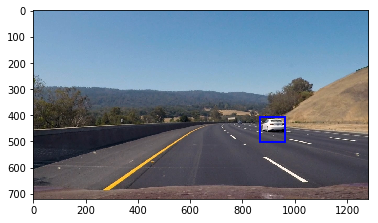

In [77]:
%matplotlib inline

img = mpimg.imread('object_test_images/test3.jpg')
  
all_boxes = []
b_boxes = find_cars(img, 360, 656, 1.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
all_boxes = all_boxes + b_boxes

b_boxes = find_cars(img, 360, 656, 1.6, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
all_boxes = all_boxes + b_boxes

b_boxes = find_cars(img, 360, 656, 1.8, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
all_boxes = all_boxes + b_boxes

bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
bgr = cv2.resize(bgr, (0,0), fx=0.3, fy=0.3) 

cv2.imwrite("output_images/test_image.jpg", bgr)

out_img =  draw_boxes(img, all_boxes)

bgr = cv2.cvtColor(out_img, cv2.COLOR_RGB2BGR)
bgr = cv2.resize(bgr, (0,0), fx=0.3, fy=0.3) 
cv2.imwrite("output_images/test_image_boxed.jpg", bgr)

plt.imshow(out_img)

# Filtering false positives and  combining overlapping bounding boxes

In [75]:
from scipy.ndimage.measurements import label
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

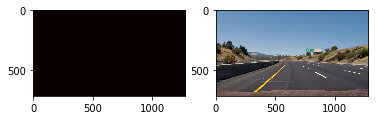

In [106]:
test_images = glob.glob('object_test_images/*')

count = 0
for image in test_images:
    count = count+1
    img = mpimg.imread(image)
    all_boxes = []    
    
    b_boxes = find_cars(img, 360, 656, 1.4, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    all_boxes = all_boxes + b_boxes
    
    b_boxes = find_cars(img, 360, 656, 1.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    all_boxes = all_boxes + b_boxes

    b_boxes = find_cars(img, 360, 656, 1.8, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    all_boxes = all_boxes + b_boxes

    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    add_heat(heat, all_boxes)

    heat = apply_threshold(heat,1)

    heatmap = np.clip(heat, 0, 255)

    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
        
    plt.subplot(121)
    plt.imshow(heat, cmap='hot')
    plt.subplot(122)
    plt.imshow(draw_img)

In [80]:
from collections import deque
all_boxes_deque = deque(maxlen=30)

def add_heat_to_video(heatmap, b_boxes_deque):
    # Iterate through list of bboxes
    for bbox_list in b_boxes_deque:
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap
    
def pipeline(img):
    all_boxes = []    
    
    b_boxes = find_cars(img, 360, 656, 1.4, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    all_boxes = all_boxes + b_boxes
    
    b_boxes = find_cars(img, 360, 656, 1.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    all_boxes = all_boxes + b_boxes

    b_boxes = find_cars(img, 360, 656, 1.8, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    all_boxes = all_boxes + b_boxes
    
    all_boxes_deque.append(all_boxes)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    add_heat_to_video(heat, all_boxes_deque)

    heat = apply_threshold(heat,15)

    heatmap = np.clip(heat, 0, 255)

    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [81]:
from moviepy.editor import VideoFileClip
output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(pipeline)
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [09:25<00:00,  2.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 10min, sys: 3.96 s, total: 10min 4s
Wall time: 9min 27s
